In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

In [3]:
BASE_PATH = "/mnt/Data/data"
base_dir = Path(BASE_PATH).resolve()

In [4]:
config = {
    "config_folder": "../data/mearec",
    "recordings_folder": str(base_dir / "output/recordings"),
    "templates_folder": str(base_dir / "output/templates")
}

In [5]:
from eapprocessor.mearec.api import generate_templates, generate_recordings, load_recordings

In [6]:
fs_list = [24000, 20000, 16000]
noise_levels = [5, 10, 15, 25]

In [7]:
all_recgen_list = [[load_recordings(datafolder=config["recordings_folder"],
                verbose=True, noise_level=noise_level, fs=fs) for noise_level in noise_levels]
               for fs in fs_list]

Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_5uV_24000Hz_2021-12-02_10-59.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_10uV_24000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_15uV_24000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_25uV_24000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_5uV_20000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Data/data/output/recordings/recordings_10cells_Neuronexus-32_10.0_10uV_20000Hz_2021-12-02_11-00.h5
Loading recordings...
Done loading recordings...
Found file /mnt/Da

In [8]:
channel_indexes=[21,27]
nthresholds = 50

In [9]:
recordings_20khz = all_recgen_list[1]
recgen=recordings_20khz[0]

In [10]:
from eapprocessor.plot.signals import plot_transient_recordings

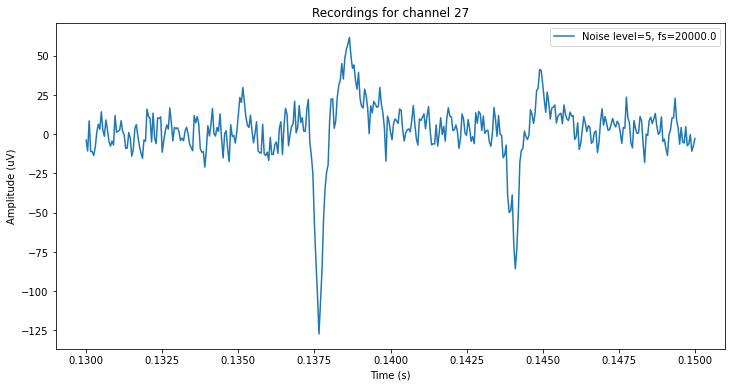

In [11]:
plot_transient_recordings(recgen, channels=[channel_indexes[1]], t_start=130e-3, t_stop=150e-3)

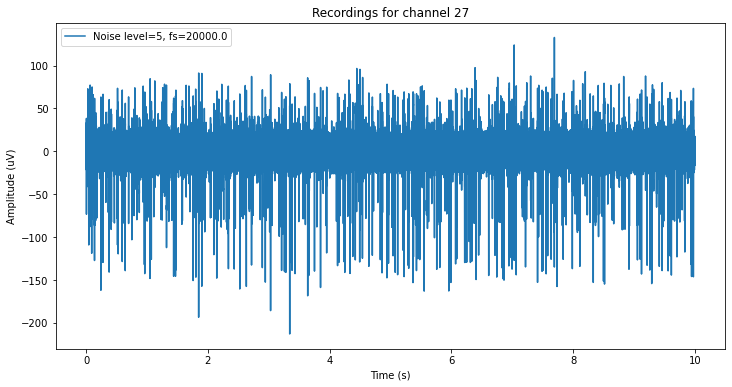

In [12]:
plot_transient_recordings(recgen, channels=[channel_indexes[1]], t_start=0)

In [13]:
import numpy as np

In [14]:
recordings = recgen.recordings[:].T
timestamps = np.array(recgen.timestamps)

In [15]:
selected = recordings[channel_indexes[1]]

In [16]:
import pandas as pd

In [17]:
df = pd.DataFrame({"time":timestamps,"vout":selected})

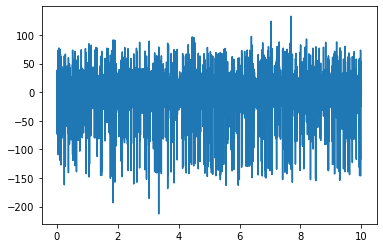

In [18]:
import matplotlib.pylab as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(df["time"],df["vout"])

In [19]:
tolerance= 2

In [20]:
df["within_tolerance"] = (np.abs(df["vout"]) <=tolerance)*1
df["within_p1"]=df["within_tolerance"].shift(periods=1, fill_value=0)
df["within_m1"]=df["within_tolerance"].shift(periods=-1, fill_value=0)
df["within_interval"] = df["within_tolerance"] * df["within_p1"] * df["within_m1"]

In [21]:
breakpoints = np.arange(1,10,1)

In [22]:
def get_breakpoint_interval(df, t_start,t_stop):
    seldf = df.loc[(df["time"]>=t_start) & (df["time"]<=t_stop)].copy()
    return seldf["within_interval"].loc[seldf["within_interval"]==1].index

def get_breakpoint_tolerance(df, breakpoint, tolerance):
    result=[]
    scale=1
    while(len(result)<1):
        print(f"scale:{scale}")
        t_start=breakpoint - tolerance*scale
        t_stop=breakpoint + tolerance*scale
        result = get_breakpoint_interval(df, t_start, t_stop)
        scale=scale*2
    return result[0]

In [23]:
n_breaks = [get_breakpoint_tolerance(df,breakpoint,5e-3) for breakpoint in breakpoints ]

scale:1
scale:1
scale:1
scale:2
scale:1
scale:1
scale:1
scale:1
scale:2
scale:4
scale:1
scale:1


In [24]:
n_breaks

[19982, 39979, 59873, 79974, 99914, 119995, 139756, 160047, 179914]

In [25]:
def get_chunks(df, indexes):
    index_l = 0
    chunks = []
    for index in indexes:
        index_h = index+1
        chunks.append(df.iloc[index_l:index_h].copy())
        index_l = index_h
    chunks.append(df.iloc[index_l:].copy())
    return chunks

In [26]:
chunks = get_chunks(df, n_breaks)
chunks

[          time       vout  within_tolerance  within_p1  within_m1   
 0      0.00000   2.311063                 0          0          0  \
 1      0.00005   9.914375                 0          0          1   
 2      0.00010   1.843763                 1          0          0   
 3      0.00015 -19.521925                 0          1          0   
 4      0.00020 -14.735105                 0          0          0   
 ...        ...        ...               ...        ...        ...   
 19978  0.99890  -8.800547                 0          0          0   
 19979  0.99895   3.703901                 0          0          0   
 19980  0.99900   3.645284                 0          0          1   
 19981  0.99905  -0.872535                 1          0          1   
 19982  0.99910   0.134945                 1          1          1   
 
        within_interval  
 0                    0  
 1                    0  
 2                    0  
 3                    0  
 4                    0  
 .

In [27]:
import matplotlib.pylab as plt

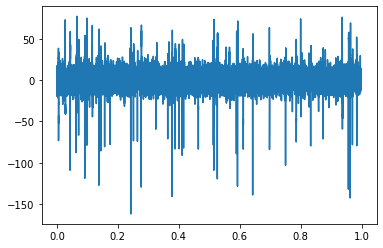

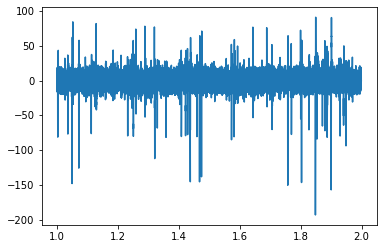

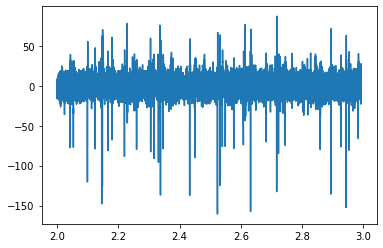

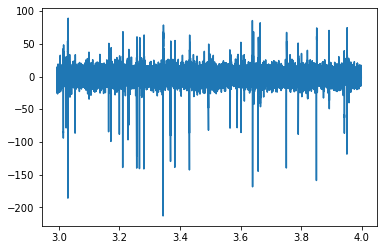

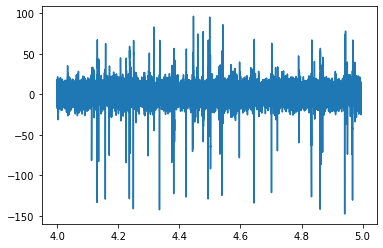

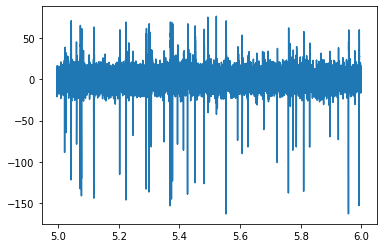

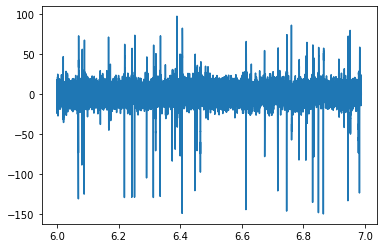

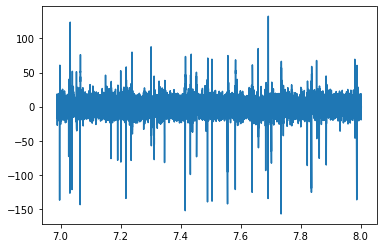

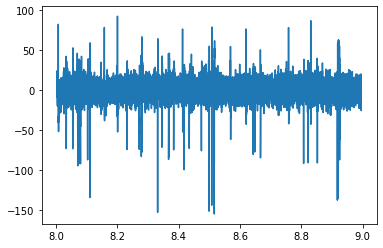

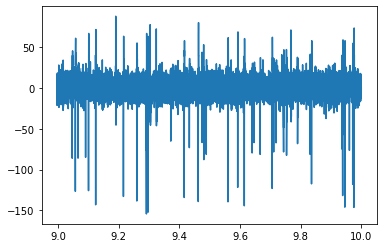

In [28]:
for chunk in chunks:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(chunk["time"],chunk["vout"])

In [29]:
def adapt_df(df, scale=1e-6):
    df["time"] = df["time"]-np.array(df["time"])[0]
    df["vout"] = df["vout"]*1e-6
    return df[["time","vout"]].copy()

In [30]:
def get_start_time(df):
    return np.array(df["time"])[0]

In [31]:
start_times = [get_start_time(chunk) for chunk in chunks]
start_times

[0.0,
 0.99915,
 1.999,
 2.9937,
 3.99875,
 4.99575,
 5.9998,
 6.98785,
 8.0024,
 8.99575]

In [32]:
chunks = [adapt_df(chunk) for chunk in chunks]

In [33]:
end_times = [np.array(chunk["time"])[-1] for chunk in chunks]
end_times

[0.9991,
 0.9998,
 0.99465,
 1.005,
 0.9969500000000004,
 1.0039999999999996,
 0.9880000000000004,
 1.0145,
 0.9932999999999996,
 1.0042000000000009]

In [34]:
folder = Path("/mnt/Archivos/Nextcloud/MaestriaPUCP/Thesis/development/project/data")
filename = "recordings_20khz_5u.csv"
filepath = folder / filename

In [35]:
from eapprocessor.tools.export import export_to_csv

In [36]:
for i, chunk in enumerate(chunks):
    chunk_file = filepath.parent /  f"{filepath.stem}_{i}{filepath.suffix}"
    # export_to_csv(chunk, chunk_file)

In [37]:
!ls -lah /mnt/Archivos/Nextcloud/MaestriaPUCP/Thesis/development/project/data

total 6.0M
drwxr-xr-x 1 luighi users 4.0K Aug  6  2022 .
drwxr-xr-x 1 luighi users 8.0K Jan 27 00:19 ..
-rw-r--r-- 1 luighi users 421K Aug  6  2022 recordings_20khz_5u_0.csv
-rw-r--r-- 1 luighi users 578K Aug  6  2022 recordings_20khz_5u_1.csv
-rw-r--r-- 1 luighi users 612K Aug  6  2022 recordings_20khz_5u_2.csv
-rw-r--r-- 1 luighi users 619K Aug  6  2022 recordings_20khz_5u_3.csv
-rw-r--r-- 1 luighi users 633K Aug  6  2022 recordings_20khz_5u_4.csv
-rw-r--r-- 1 luighi users 637K Aug  6  2022 recordings_20khz_5u_5.csv
-rw-r--r-- 1 luighi users 632K Aug  6  2022 recordings_20khz_5u_6.csv
-rw-r--r-- 1 luighi users 643K Aug  6  2022 recordings_20khz_5u_7.csv
-rw-r--r-- 1 luighi users 640K Aug  6  2022 recordings_20khz_5u_8.csv
-rw-r--r-- 1 luighi users 646K Aug  6  2022 recordings_20khz_5u_9.csv


In [38]:
n_breaks

[19982, 39979, 59873, 79974, 99914, 119995, 139756, 160047, 179914]

In [40]:
n_breaks.append(df.index[-1])

In [41]:
n_breaks

[19982, 39979, 59873, 79974, 99914, 119995, 139756, 160047, 179914, 199999]

In [42]:
h_limit_idx=n_breaks
l_limit_idx=[0] + [i+1 for i in n_breaks[:-1]]
print(h_limit_idx)
print(l_limit_idx)

[19982, 39979, 59873, 79974, 99914, 119995, 139756, 160047, 179914, 199999]
[0, 19983, 39980, 59874, 79975, 99915, 119996, 139757, 160048, 179915]


In [43]:
bdf=pd.DataFrame(zip(l_limit_idx,h_limit_idx), columns=["l_limit_idx","h_limit_idx"])
bdf

,l_limit_idx,h_limit_idx
0,0,19982
1,19983,39979
2,39980,59873
3,59874,79974
4,79975,99914
5,99915,119995
6,119996,139756
7,139757,160047
8,160048,179914
9,179915,199999


In [47]:
bdf["l_limit"]=np.array(df["time"][bdf["l_limit_idx"]])
bdf["h_limit"]=np.array(df["time"][bdf["h_limit_idx"]])
bdf

,l_limit_idx,h_limit_idx,l_limit,h_limit
0,0,19982,0.00000,0.99910
1,19983,39979,0.99915,1.99895
2,39980,59873,1.99900,2.99365
3,59874,79974,2.99370,3.99870
4,79975,99914,3.99875,4.99570
5,99915,119995,4.99575,5.99975
6,119996,139756,5.99980,6.98780
7,139757,160047,6.98785,8.00235
8,160048,179914,8.00240,8.99570
9,179915,199999,8.99575,9.99995


In [52]:
filename = str(base_dir / "breakpoints.csv")

In [55]:
export_to_csv(bdf, str(filename),header=True)